# Task 1: Find The Prime Numbers

#### Given a positive integer and a list of prime numbers, look for the two prime numbers that sum to the positive number.

## Loading Libraries:

In [1]:
import numpy as np
import math
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.basis_change import QFT

## Distinct Unordered Tuples:
#### The implementation of the following function removes redundant decompositions.

In [2]:
def increasing_tuple(input_list):
    # Stores the pairs
    increasing_pairs = []
    
    # Orders the pairs such that the first number is less than or equal to the second
    for i in range(len(input_list)):
        for j in range(len(input_list)):
            if input_list[i]<= input_list[j]:
                increasing_pairs.append((input_list[i], input_list[j]))
            else:
                pass
    return increasing_pairs

## Targeting Bits:
#### The following function will target the bits which represents elements in our list.

In [3]:
def target_set_circuit(input_list):
    # Constructs distinct unordered pairs
    pairs = increasing_tuple(input_list)
    
    # Determines the necessary bits required to represent our elements
    num_qubits = int(np.log2(max(input_list)))+1
    
    # We have an n qubits in the first register, (n+1) qubits in the second register, and 2 ancillas.
    ts_circuit = QuantumCircuit(2*num_qubits+3)
    
    # Performs  bit flips on the elements in the unordered pair and applies x-gates to the corresponding 1's 
    for j in range(len(pairs)):
        for i in range(num_qubits):
            if ''.join('1' if x == '0' else '0' for x in bin(pairs[j][0])[2:].zfill(num_qubits))[num_qubits-i-1] == '1':
                ts_circuit.x(i)
            if ''.join('1' if x == '0' else '0' for x in bin(pairs[j][1])[2:].zfill(num_qubits))[num_qubits-i-1] == '1':
                ts_circuit.x(num_qubits + i)
                
        # Bit flips an ancilla to mark the target state
        ts_circuit.mcx(list(range(2*num_qubits)), 2*num_qubits+1)
        
        # Reverses back to the previous state with the ancilla still marked
        for i in range(num_qubits):
            if ''.join('1' if x == '0' else '0' for x in bin(pairs[j][0])[2:].zfill(num_qubits))[num_qubits-i-1] == '1':
                ts_circuit.x(i)
            if ''.join('1' if x == '0' else '0' for x in bin(pairs[j][1])[2:].zfill(num_qubits))[num_qubits-i-1] == '1':
                ts_circuit.x(num_qubits + i)
        ts_circuit.barrier(range(2*num_qubits+3))
    return ts_circuit

## Constructing The Quantum Adder:
#### Through the quantum fourier transform, the following function adds the first register onto the second. This eliminates the need for temporary qubits.

In [4]:
def quantum_add_circuit(qubits, target_number):
    # The additional qubit is to store the qubit after the sum
    qa_circuit = QuantumCircuit(2*qubits+1)
    
    # The following gate changes the basis of the second register from the computational basis to the fourier basis
    qa_circuit.append(QFT(qubits+1, do_swaps=False), list(range(qubits, 2*qubits+1)))
    
    # Constructs a circuit which counts in the fourier basis by applying rotations in the presence of 1 qubits
    for j in range(qubits):
        for k in range(qubits+1-j):
            lamda = np.pi / (2 ** (k))
            qa_circuit.cp(lamda, j, k+j+qubits)
            
    # This gate changes from the fourier basis back to the computational basis
    qa_circuit.append(QFT(qubits+1,do_swaps=False).inverse(), list(range(qubits, 2*qubits+1)))
    
    # This gate changes the target to correspond to the all 1's state in the second register by performing bit flips
    for i in range(qubits+1):
            if ''.join('1' if x == '0' else '0' for x in bin(target_number)[2:].zfill(qubits+1))[qubits-i] == '1':
                qa_circuit.x(i+qubits)
    return qa_circuit

## Constructing The Oracle:
#### The following circuit performs a phase flip on the states which have the 11 state on the ancillas. This corresponds to elements in the set which sum to the target. 

In [5]:
def oracle_circuit(target_number, input_list):
    # Determines the size of the circuit based on the list
    num_qubits = int(np.log2(max(input_list)))+1
    
    # Constructs circuit which marks the correct states using the target_set_circuit and the quantum_add_circuit
    ts_circuit = target_set_circuit(input_list)
    qa_circuit = quantum_add_circuit(num_qubits, target_number)
    o_circuit = QuantumCircuit(2*num_qubits+3)
    o_circuit.append(ts_circuit, range(2*num_qubits+3))
    o_circuit.append(qa_circuit, range(2*num_qubits+1))
    
    # Marks the state with the correct sum
    o_circuit.mcx(list(range(num_qubits, 2*num_qubits+1)), 2*num_qubits+2)
    
    # Performs a phase flip on the 11 ancillas
    o_circuit.cz(2*num_qubits+1,2*num_qubits+2)
    
    # Reverses to the previous state except with a sign change on the amplitude for the correct states
    o_circuit.mcx(list(range(num_qubits, 2*num_qubits+1)), 2*num_qubits+2)
    o_circuit.append(qa_circuit.inverse(), range(2*num_qubits+1))
    o_circuit.append(ts_circuit.inverse(), range(2*num_qubits+3))
    return o_circuit

## Constructing The Diffusion Operator:
#### The following circuit applies the diffusion operator which amplifies the correct state.

In [6]:
def diffusion_circuit(qubits):
    # Determines the size of the circuit
    d_circuit = QuantumCircuit(2*qubits+1)
    
    # Reverses our state which was initialized with hadamard gates
    d_circuit.h(range(2*qubits))
    
    # Performs the reflection across the all 0's state
    d_circuit.x(range(2*qubits))
    d_circuit.h(2*qubits-1)
    d_circuit.mct(list(range(2*qubits-1)), 2*qubits-1) 
    d_circuit.h(2*qubits-1)
    d_circuit.x(range(2*qubits))
    
    # Reinitializes our state by applying hadamard gates 
    d_circuit.h(range(2*qubits))
    return d_circuit

## Implementing Grover's Algorithm:
#### The following circuit implements Grover's Algorithm by applying iterations of the oracle and the diffusion operator. 

In [7]:
def prime_number_circuit(target_number, input_list):
    # Determines size of the circuit
    num_qubits = int(np.log2(max(input_list)))+1
    
    # Constructing circuits
    o_circuit = oracle_circuit(target_number, input_list)
    d_circuit = diffusion_circuit(num_qubits)
    pn_circuit = QuantumCircuit(2*num_qubits+3, 2*num_qubits)
    
    # Initializes to the equal superposition state
    pn_circuit.h(range(2*num_qubits))
    pn_circuit.barrier(range(2*num_qubits+3))
    
    # Applies the Grover's Operator where the number of applications depends on the size of the circuit
    for j in range(int(math.pi/4*math.sqrt(2**(2*num_qubits)))):
        pn_circuit.append(o_circuit, range(2*num_qubits+3))
        pn_circuit.append(d_circuit, range(2*num_qubits+1))
        
    # Measures the first 2n qubits
    pn_circuit.measure(list(range(2*num_qubits)),list(range(2*num_qubits)))
    return pn_circuit

## Determining The Decomposition:
#### We run an arbitrary number of simulations to find the most probable decomposition. 

In [8]:
def find_prime_numbers(target_number, input_list):
    # Setting up the simulator
    simulator = Aer.get_backend('qasm_simulator')
    
    # Determines the size of the circuit
    num_qubits = int(np.log2(max(input_list)))+1
    
    # Produces an error if the sum is not possible
    if target_number > 2*max(input_list):
        print(f"The number {target_number} exceeds the maximum possible sum in {input_list}.")
        return (None, None)
    
    # Simulates circuit
    pn_circuit = prime_number_circuit(target_number, input_list)
    count_quantum_circuit = execute(pn_circuit, backend = simulator, shots = 10000).result().get_counts()
    
    # Counts the number of times each 2n bit appears and picks the most frequent one
    max_binary_counts = 0
    max_binary_value = ''
    for key, item in count_quantum_circuit.items():
        if item > max_binary_counts:
            max_binary_counts = item
            max_binary_value = key
            
    # Converts the n bits from the registers to integers
    a_value = int(max_binary_value[-num_qubits:],2)
    b_value = int(max_binary_value[:num_qubits],2)
    
    # Checks if the decomposition is correct
    if target_number != a_value+b_value: 
        print(f"The quantum algorithm could not decompose {target_number} as a sum of two elements in {input_list}.")
        return (None, count_quantum_circuit)
    
    # If correct, states the decomposition
    print(f"The number {target_number} can be decomposed as {a_value}+{b_value}.")
    # Stores the values as well as the count data
    return (a_value, b_value), count_quantum_circuit

# Testing:
#### We test the function for various inputs.

## Test 1:

In [9]:
(values_1,count_1) = find_prime_numbers(6, [2,3])

The number 6 can be decomposed as 3+3.


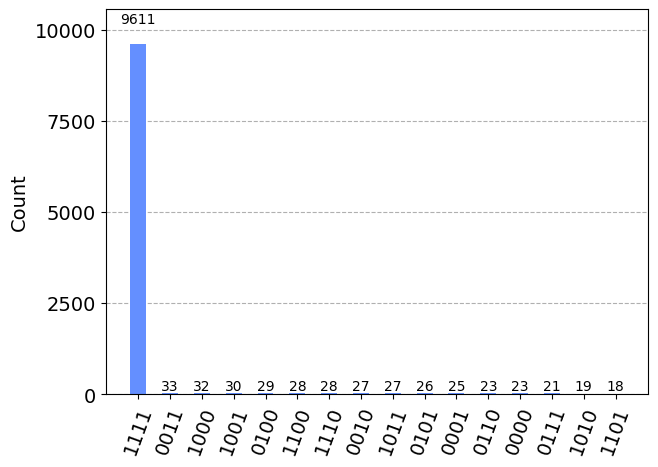

In [10]:
# Plots the number of counts in decreasing order
plot_histogram(count_1, sort='value_desc')

#### We can see that the state 1111 has been amplified. This corresponds to the bits 11 and 11 which we convert to 3 and 3.

## Test 2:

In [11]:
(values_2,count_2) = find_prime_numbers(4, [3])

The quantum algorithm could not decompose 4 as a sum of two elements in [3].


#### From this test, we can see that the circuit has determined it is unlikely the target number can be decomposted. This is reflected in the the plot.

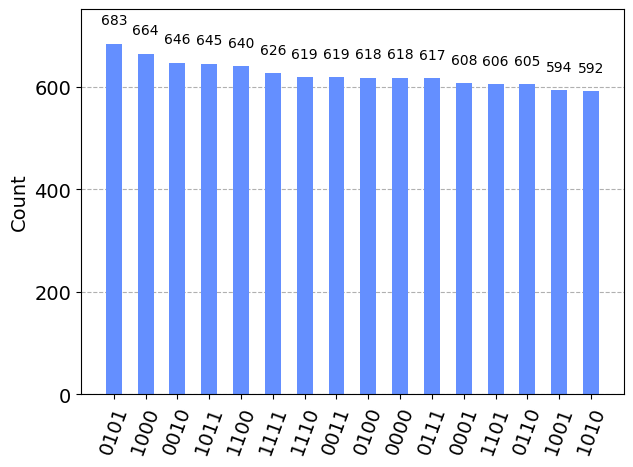

In [12]:
# Plots the number of counts in decreasing order
plot_histogram(count_2, sort='value_desc')

#### Since the oracle does not see any solutions, we can see in the plot that no states are amplified.

## Test 3:
#### We now test a few larger values.

In [13]:
(values_3,count_3) = find_prime_numbers(18, [1,3,5,7,11,13,15])

The number 18 can be decomposed as 5+13.


## Test 4:

In [14]:
(values_4,count_4) = find_prime_numbers(32, [2,3,5,7,11,13,17,19])

The number 32 can be decomposed as 13+19.


## Test 5:

In [15]:
(values_5,count_5) = find_prime_numbers(33, [2,3,5,7,11,13,17,19])

The quantum algorithm could not decompose 33 as a sum of two elements in [2, 3, 5, 7, 11, 13, 17, 19].


#### The test determines that there is no decomposition.

## Drawing The Circuit:
#### We draw the circuit involved one iteration of the Grover's Operation.

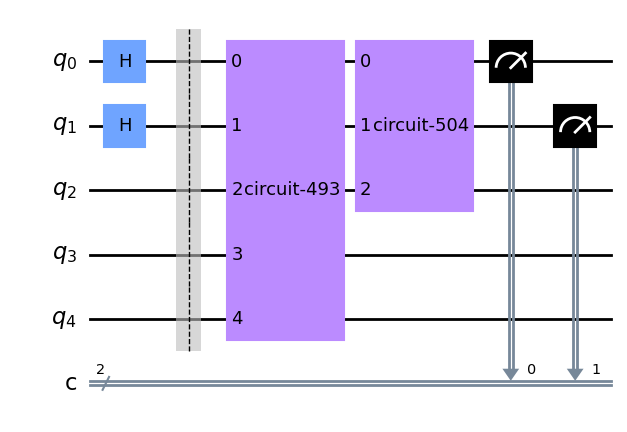

In [16]:
prime_number_circuit(2,[1]).draw('mpl')

## Remark:
#### Although the task states that the input list contains prime numbers, the constructed circuit works for any list of positive integers.